In [2]:
!pip install tensorflow
!pip install tokenizers
!pip install transformers

In [3]:
import collections
from collections import defaultdict
import csv
import functools
import itertools
import re
import string
import timeit
from timeit import default_timer
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel, TFAutoModel

from utils import *
from topic_utils import *

### Data

In [4]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [5]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

# Sentiment Analysis

Download the Cardiff NLP Twitter pre-trained roBERTa base model:

In [6]:
task = 'sentiment'

MODEL = "cardiffnlp/twitter-roberta-base-{}".format(task)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [7]:
model.config

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [8]:
def get_sentiment_dict(iter_of_docs):
    
    sentiments = []

    for doc in iter_of_docs:
        encoded_input = tokenizer(doc, return_tensors='tf')
        output = model(encoded_input)
        scores = output[0][0].numpy()
        scores = softmax(scores)

        sentiments.append(labels[np.argmax(scores)])

    return dict(zip(documents, sentiments))

In [9]:
def get_sentiment(document):
    """Usage: df.apply(get_sentiment)"""
    encoded_input = tokenizer(document, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)

    return labels[np.argmax(scores)]#, np.max(scores)

In [15]:
def get_model(model, task):
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    tokenizer.add_tokens(['[HTAG]', '[URL]', '[AT]'])
    
    return model, tokenizer
    
def get_labels(csv_link):
    with urllib.request.urlopen(csv_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    return [row[1] for row in csvreader if len(row) > 1]
    
def predict_sentiment(document, model, labels):
    # preprocess
    document = preprocess_string(document)
    
    # tokenize
    encoded_input = tokenizer(document, return_tensors='tf')
    
    # apply model
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)

    return labels[np.argmax(scores)]

In [11]:
task = 'sentiment'
MODEL = 'cardiffnlp/twitter-roberta-base-{}'.format(task)

model, tokenizer = get_model(MODEL, task)

labels = get_labels('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{}/mapping.txt'.format(task))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Apply only to English tweets (model has been trained on English):

In [14]:
model.config

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [12]:
documents = (campaign
 .groupby('tweet_language')
 .get_group('en')['tweet_text']
).head(100)

documents.iloc[0]

"Why there's a bird sound? And why it's upside down? https://t.co/FK8pOY2PqU"

In [17]:
predict_partial = functools.partial(predict_sentiment, labels=labels, model=model)
# todo: make this much faster
t1 = default_timer()

sentiment = (documents
             .apply(preprocess_string)
             .apply(predict_partial)
            )
print('elapsed: {}'.format(default_timer() - t1))

elapsed: 11.72276159498142


In [18]:
df_abbrv = pd.DataFrame(documents)
df_abbrv['sentiment'] = sentiment
df_abbrv.head(10)

,tweet_text,sentiment
tweetid,,
907991739713118208,Why there's a bird sound? And why it's upside ...,neutral
1277789135470768129,Malawi is using bamboo to fight #climatechange...,positive
1314271851988873251,😷Right in the middle of an illness😷 ..... #Bla...,negative
1298084197773520898,"Scotland’s Climate Assembly, doing politics di...",neutral
1291999805770694656,It's an urgent warning from climate scientists...,neutral
1281483637997940736,Economic inequality is out of control... This ...,negative
1302115414919401473,DR. Anthony Fauci: I congratulate Russians to ...,negative
1267652700537315331,I can't breath... #HumanRights #HumanRightsVi...,negative
1243826214630031360,A major exhibition hall in Vienna has been tra...,neutral


In [19]:
(df_abbrv
.groupby('sentiment')
.get_group('negative')
).head(10)

,tweet_text,sentiment
tweetid,,
1314271851988873251,😷Right in the middle of an illness😷 ..... #Bla...,negative
1281483637997940736,Economic inequality is out of control... This ...,negative
1302115414919401473,DR. Anthony Fauci: I congratulate Russians to ...,negative
1267652700537315331,I can't breath... #HumanRights #HumanRightsVi...,negative
1289552966752460802,"Alexander Vindman retires,cites 'bullying' by ...",negative
1269827106042720258,This is what oppression of a black live looks ...,negative
1222143276951601153,"I don't understand his language, but my heart ...",negative
1299400387078881281,can't name one because he ruined everything fo...,negative
1300830299786543104,The Role of Law Enforcement in Supporting Pede...,negative


## Event-related sentiment

In [20]:
grouped = (campaign
 .reset_index()
 .set_index('tweet_time')
 .resample('D')[['tweetid','userid','tweet_text','tweet_language']]
)

top_day = (grouped
 .size()
 .sort_values(ascending=False)
).idxmax()

top_day_tweets = grouped.get_group(top_day)
top_day_tweets.head(5)

,tweetid,userid,tweet_text,tweet_language
tweet_time,,,,
2020-08-17 00:02:00,1295149036681474048,213589457,RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8...,es
2020-08-17 00:02:00,1295149057372033024,jWkurFac8vhkrkKlTqvhjp4rwEVXCuZ7uOhVc+bs1ZY=,@safewordthe2nd @Mahyargdrz عه نه! چرا!؟ پس کی...,fa
2020-08-17 00:15:00,1295152130546900995,213589457,Una fuente saudí afirma que el príncipe herede...,es
2020-08-17 00:30:00,1295155883819667458,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,Dirgahayu RI ke 75 Jangan sia-siain jasa pah...,in
2020-08-17 00:30:00,1295155884205789185,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,"""Kita berutang kepada Palestina. Palestina yan...",in


In [21]:
english_tweets = (top_day_tweets
                  .groupby('tweet_language')
                  .get_group('en')
                 )
english_tweets.head(5)

,tweetid,userid,tweet_text,tweet_language
tweet_time,,,,
2020-08-17 00:30:00,1295155883857436672,6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=,We stand with Palestine. Isreal occupation of ...,en
2020-08-17 00:30:00,1295155884193124353,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,SHAME ON UAE !!! #UAEBetraysPalestine https:/...,en
2020-08-17 00:30:00,1295155883945521152,79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=,It has always been Palestine and it always wil...,en
2020-08-17 00:30:00,1295155884855762944,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,"tomorrow is Indonesia's independence, this can...",en
2020-08-17 00:31:00,1295156135587123201,79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=,We stand by the Palestine and Yaman Until the...,en


In [23]:
t1 = default_timer()

sentiment = (english_tweets['tweet_text']
             .apply(preprocess_string)
             .apply(predict_partial)
            )
print('elapsed: {}'.format(default_timer() - t1))

elapsed: 119.94197515398264


In [24]:
english_tweets = pd.DataFrame(english_tweets)
english_tweets['sentiment'] = sentiment
english_tweets[['tweet_text','sentiment']].head(10)

,tweet_text,sentiment
tweet_time,,
2020-08-17 00:30:00,We stand with Palestine. Isreal occupation of ...,negative
2020-08-17 00:30:00,SHAME ON UAE !!! #UAEBetraysPalestine https:/...,negative
2020-08-17 00:30:00,It has always been Palestine and it always wil...,neutral
2020-08-17 00:30:00,"tomorrow is Indonesia's independence, this can...",neutral
2020-08-17 00:31:00,We stand by the Palestine and Yaman Until the...,neutral
2020-08-17 00:32:00,Normalization of israil = betrayal of the Musl...,negative
2020-08-17 00:34:00,If u forget we would never forget !! #UAEBetra...,neutral
2020-08-17 00:34:00,The goal is to destroy Israel #UAEBetraysPales...,negative
2020-08-17 00:35:00,Stop this treason to the Arabs further more to...,negative


In [25]:
grouped = (english_tweets
.groupby('sentiment')
)
grouped.size()

sentiment
negative    540
neutral     389
positive     85
dtype: int64

In [26]:
positive = grouped.get_group('positive')['tweet_text']
positive[:5]

tweet_time
2020-08-17 00:43:00    RT @My1ManArmy: Very strong words.

#UAEStabsM...
2020-08-17 00:48:00    RT @BadriaNaila: Palestine, don't be disappoin...
2020-08-17 00:48:00    RT @BadriaNaila: Palestine, we still love you ...
2020-08-17 01:33:00    Verily God  is  with the truthful and Palestin...
2020-08-17 01:57:00    we are not like arabs we are much better than ...
Name: tweet_text, dtype: string

In [27]:
tokens = make_tokens(positive)

In [28]:
freq_dict = word_frequency(long_list(tokens))

### Visualize positive keywords

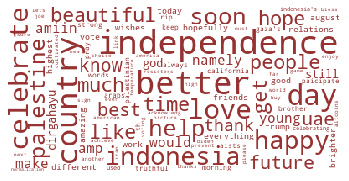

In [29]:
fig = visualize(freq_dict)

### Visualize negative keywords

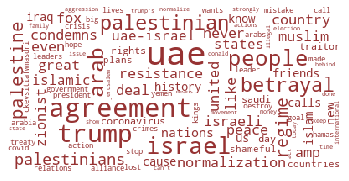

In [30]:
negative = grouped.get_group('negative')['tweet_text']
freq = word_frequency(long_list(make_tokens(negative)))
fig = visualize(freq)

#### To Do:
- separate tweets by language + use different models
    - make sure they have the same labels

In [31]:
(campaign['tweet_language']
.value_counts()
.sort_values(ascending=False))[:10]

es     193843
en     115723
in      57947
fa      43765
und     15708
ar       7245
fr       6015
pt        792
tl        759
ca        439
Name: tweet_language, dtype: Int64

## Spanish language tweets

In [33]:
!pip install pysentimiento

In [34]:
from pysentimiento import SentimentAnalyzer
analyzer = SentimentAnalyzer(lang="es")

In [35]:
documents = (campaign
 .groupby('tweet_language')
 .get_group('es')['tweet_text']
).head(100)

In [36]:
t1 = default_timer()

sentiment = (documents
             .apply(analyzer.predict)
             .apply(lambda x: x.output)
            )
print('elapsed: {}'.format(default_timer() - t1))

elapsed: 3.7149138579843566


In [38]:
sentiment

tweetid
1287686936698781703    POS
1309019270370799618    NEG
1294191167446364161    NEU
1290666171444887559    NEG
1303173676821557248    NEG
                      ... 
1289966789061992449    NEU
1296079679418519559    NEG
1297556704826200064    NEU
1298641242675466240    NEG
1288150034723348480    POS
Name: tweet_text, Length: 100, dtype: object

In [37]:
documents = pd.DataFrame(documents)
documents['sentiment'] = sentiment['sentiment']
documents[['tweet_text','sentiment']].head(10)

KeyError: 'sentiment'

In [ ]:
((documents
.groupby('sentiment')
.get_group('POS')
).head(10)['tweet_text']).to_list()